# Classifier

1. Logistic regression (https://www.datacamp.com/community/tutorials/understanding-logistic-regression-python)


functions:
https://scikit-learn.org/stable/modules/feature_selection.html

example:
https://scikit-learn.org/stable/auto_examples/feature_selection/plot_feature_selection.html#sphx-glr-auto-examples-feature-selection-plot-feature-selection-py

tut:
https://medium.com/@GouthamPeri/pipeline-with-tuning-scikit-learn-b2789dca9dc2

https://stackoverflow.com/questions/33376078/python-feature-selection-in-pipeline-how-determine-feature-names

## Import packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm
import random
random.seed(32)
import sklearn
# from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif, VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import precision_recall_curve
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Import data

In [2]:
df = pd.read_pickle("wordlists.pkl")
df.head()
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84619 entries, 0 to 84618
Data columns (total 4853 columns):
 #     Column                           Dtype  
---    ------                           -----  
 0     index                            int64  
 1     author                           object 
 2     body_x                           object 
 3     probody                          object 
 4     tokens                           object 
 5     senttokens                       object 
 6     agreeableness                    float64
 7     openness                         float64
 8     conscientiousness                float64
 9     extraversion                     float64
 10    neuroticism                      float64
 11    agree                            int64  
 12    openn                            int64  
 13    consc                            int64  
 14    extra                            int64  
 15    neuro                            int64  
 16    language          

## Trait

In [3]:
#split dataset in features and target variable depending on which trait to focus on
def trait(df, trait_name, startnumber):
    featurelist = df.columns.tolist()
    feature_cols = featurelist[startnumber:]
#     print(len(feature_cols))
    x = df[feature_cols] 
    
    if trait_name == 'agree':
        y = df.agree
    elif trait_name == 'openn':
        y = df.openn
    elif trait_name == 'consc':
        y = df.consc
    elif trait_name == 'extra':
        y = df.extra
    elif trait_name == 'neuro':
        y = df.neuro       
    return x,y 

# x,y = trait(df, 'extra', 35)

## Classifier

1. Logistic regression

In [4]:
def logclassifier(x_train,y_train, x_test):
    # instantiate the model (using the default parameters)
    logreg = LogisticRegression()
    # fit the model with data
    logreg.fit(x_train,y_train)
#     y_pred=logreg.predict(x_test)    
    return logreg

# logreg = logclassifier(x_train,y_train, x_test)
# y_pred=logreg.predict(x_test)



# ANOVA feature selection for numeric input and categorical output

def create_pipeline(x ,y ,classifier):
    if classifier == "log":
        pipeline = Pipeline([
          ('variance_threshold', VarianceThreshold()),
          ('feature_selection',  SelectKBest(f_classif, k=30)),
          ('classification',LogisticRegression())
        ])
        
    pipeline.fit(x, y)
    return pipeline

# logpipe = create_pipeline('log')
# y_pred=logpipe.predict(x_test)

# print("shape of x before feature selection", x.shape)
# x_new = SelectKBest(f_classif, k=30).fit_transform(x, y)
# print("shape of x after feature selection", x_new.shape)

## Get names of 30 most important features

In [5]:
# get names of the features
def get_names(x, pipeline):
    features = pipeline.named_steps['feature_selection']
    names = x.columns[features.get_support(indices=True)]
    return names

# names = get_names(logpipe)
# print(names)

## Scores

In [6]:
def scores(y_test, y_pred):
    
    accuracy=metrics.accuracy_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    recall=metrics.recall_score(y_test, y_pred)
    f_one=metrics.f1_score(y_test, y_pred)
    return accuracy, precision, recall, f_one

# accuracy, precision, recall, f_one = scores(y_test, y_pred)

# print("Accuracy:",accuracy)
# print("Precision:",precision)
# print("Recall:",recall)
# print("F1:",f_one)   


def score_plot(logreg, y_test, x_test):
    lr_probs = logreg.predict_proba(x_test)
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]
    # predict class values
#     yhat = logreg.predict(x_test)
    lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
#     lr_f1, lr_auc = f1_score(y_test, yhat), auc(lr_recall, lr_precision)

    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    fig, ax = plt.subplots()
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    # show the legend
    plt.legend()
    
    return lr_precision, lr_recall



# Smaller values on the x-axis of the plot:
#         indicate lower false positives and higher true negatives.
# Larger values on the y-axis of the plot:
#         indicate higher true positives and lower false negatives.



## Create and print confusion matrix

In [7]:
def create_cnfmatrix(y_test, y_pred, plotting=True):
    cnfpipe_matrix = metrics.confusion_matrix(y_test, y_pred)
#     print(cnfpipe_matrix)
    
    if plotting:
        %matplotlib inline
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnfpipe_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
        
# cnfmatrix = create_cnfmatrix(y_test, y_pred, True)

# Wrapper

In [8]:
def classify(df, trait_name, startnumber, plotting=True):
    print("Trait to predict: ", trait_name)
    x,y = trait(df, trait_name, startnumber)
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=0)
    logpipe = create_pipeline(x, y, 'log')
    y_pred=logpipe.predict(x_test)
    names = get_names(x, logpipe)
    print("Names of the top 30 features: ", names, "\n")
    cnfmatrix = create_cnfmatrix(y_test, y_pred, plotting=True)
    accuracy, precision, recall, f_one = scores(y_test, y_pred)
    print("Scores:\nAccuracy:",accuracy, "\nPrecision:",precision, "\nRecall:",recall, "\nF1 score:",f_one)
    lr_precision, lr_recall = score_plot(logpipe, y_test, x_test)
#     print("Scores:\nLR_Precision:",lr_precision, "\nLR_Recall:",lr_recall)

# startnumber ngrams : 35
# startnumber wordlists: 28
# startnumber: linguistic features: 29

Trait to predict:  agree


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Names of the top 30 features:  Index(['forget', 'forget limit', 'forget limit good', 'limit', 'limit good',
       'sound', 'suggest', 'suggest forget', 'suggest forget limit', 'tangl',
       'tangl web', 'wear heart sleev', 'wth thought no', 'yeah', 'yeah zero',
       'zero', 'agu', 'ah', 'eag', 'eav', 'gg', 'ime', 'lik', 'min', 'sor',
       'suf', 'tal', 'ug ', 'wea', 'ye '],
      dtype='object') 

Scores:
Accuracy: 0.9998581895532971 
Precision: 1.0 
Recall: 0.9230769230769231 
F1 score: 0.9600000000000001


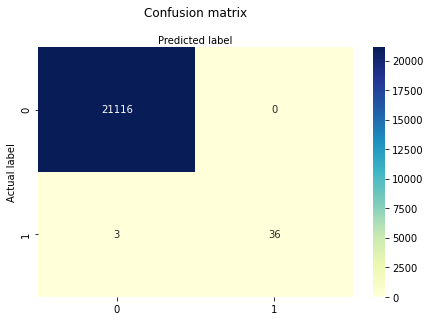

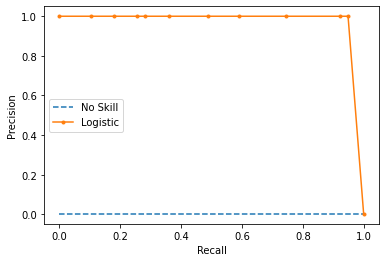

In [9]:
# Agreeableness
classify(df, "agree", 28, plotting=True)

Trait to predict:  openn


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Names of the top 30 features:  Index(['pasttense', 'say_x', 'seen', ' du', ' na', ' s', ' sw', ' to', '5x1',
       'cce', 'col', 'd b', 'eba', 'ecr', 'edi', 'eem', 'hav', 'hel', 'i s',
       'll', 'ou ', 'out_y', 's t', 'saw_y', 'sec', 't v', 'tow', 'uld',
       'humans', 'exclusive'],
      dtype='object') 

Scores:
Accuracy: 0.9997636492554951 
Precision: 0.9998258345428157 
Recall: 0.9998838829540176 
F1 score: 0.9998548579058899


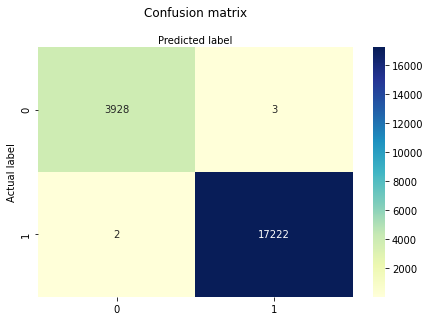

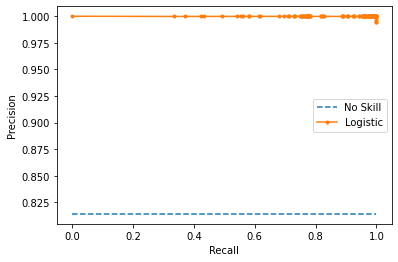

In [10]:
# Openness
classify(df, "openn", 28, plotting=True)

Trait to predict:  consc


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Names of the top 30 features:  Index(['pasttense', 'not_x', 'say_x', 'seen', ' du', ' na', ' s', ' sw', ' to',
       '5x1', 'cce', 'col', 'd b', 'eba', 'ecr', 'edi', 'eem', 'hav', 'hel',
       'i s', 'll', 'out_y', 's t', 'saw_y', 'sec', 't v', 'tow', 'uld',
       'humans', 'exclusive'],
      dtype='object') 

Scores:
Accuracy: 0.9972583313637438 
Precision: 0.9997456118036123 
Recall: 0.9857035364936042 
F1 score: 0.9926749179085628


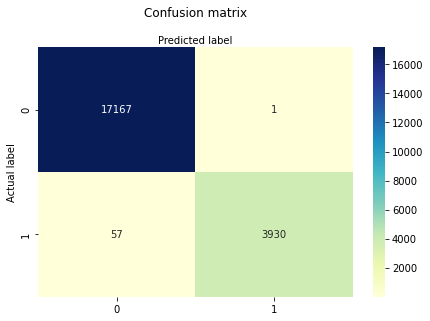

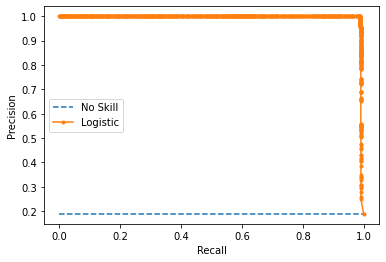

In [11]:
# Conscientiousness
classify(df, "consc", 28, plotting=True)

Trait to predict:  extra


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Names of the top 30 features:  Index(['ups', 'dom_x', 'hell', 'noth', 'play', ' de', 'br', 'co ', 'dir',
       'e c', 'fic', 'gro', 'gu', 'hee', 'i r', 'im_y', 'iou', 'lax', 'lyz',
       'm ', 'o t', 'om', 'rfo', 'say_y', 'shi', 'sop', 't u', 'ths', 'typ',
       'emotional'],
      dtype='object') 

Scores:
Accuracy: 0.9808555896951076 
Precision: 0.9765339822701199 
Recall: 1.0 
F1 score: 0.9881276932547709


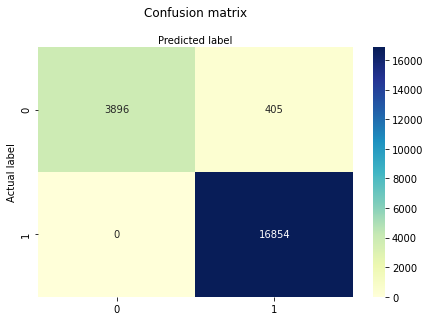

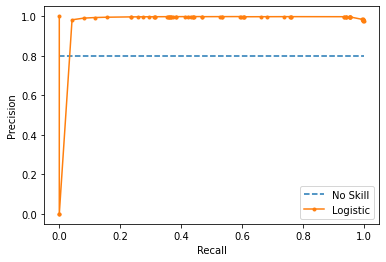

In [12]:
# Extraversion 
classify(df, "extra", 28, plotting=True)

Trait to predict:  neuro


/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:78: RuntimeWarning: Degrees of freedom <= 0 for slice.
  self.variances_ = np.nanvar(X, axis=0)
/home/sophia/ma_py/.venv/lib/python3.8/site-packages/sklearn/feature_selection/_variance_threshold.py:86: RuntimeWarning: All-NaN slice encountered
  self.variances_ = np.nanmin(compare_arr, axis=0)


Names of the top 30 features:  Index(['cod_x', 'cod one', 'im_x', 'im play', 'im play cod', 'like descript',
       'like descript vagu', 'no way', 'no way hell', 'not like',
       'not like descript', 'play cod', 'play cod one', 'short', 'short also',
       'short also wth', 'thought', 'thought no', 'util support sniper',
       'vagu', 'vagu disorgan', 'way bless mossi', 'would work type', 'wth_x',
       'wth thought', 'hi', 'lyz', 'ore', 'pay_y', 'sop'],
      dtype='object') 

Scores:
Accuracy: 0.977026707634129 
Precision: 1.0 
Recall: 0.8755441741357234 
F1 score: 0.9336428181321682


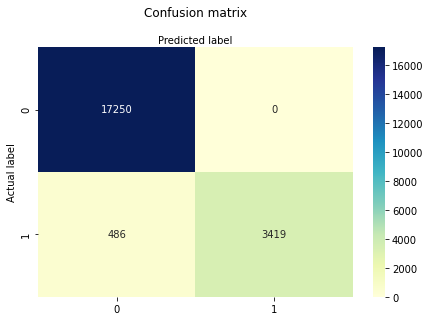

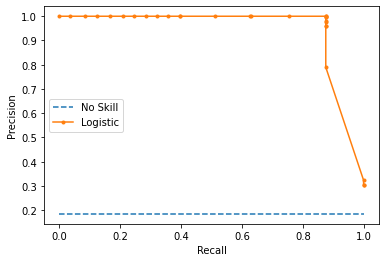

In [13]:
# Neuroticism
classify(df, "neuro", 28, plotting=True)